In [1]:
from pycausal import *
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
### (X^3 + X - X^2) * sin(X) 
base = SCM("Observational Source Model")
X = Variable("X", stats.uniform(-2,5))
Ny = HiddenVariable("Ny",stats.beta(0.2,0.2)) 

y2 = multiply( sin(X), scale(2, negative(X) ) )

Y = add(y2, Ny).mark("Y")

In [18]:
### with covariance shift
interv = SCM("Interventional Source Model")
iX = Variable("iX", stats.uniform(-2,5))
P = placeholder("P")

X = add(P, iX).mark("X")
Ny = HiddenVariable("Ny",stats.beta(0.1,0.1)) 

y2 = multiply( sin(X), scale(2, negative(X) ) )

Y = add(y2, Ny).mark("Y")

Perturbation = Variable("Perturbation", stats.uniform(1,2))
transfer = interv.intervene({P: Perturbation})

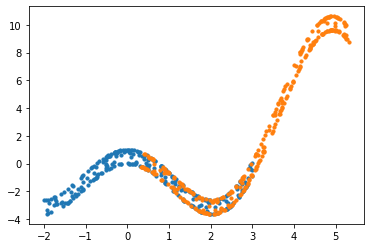

In [19]:
smps = base._sample(300)
ints = transfer._sample(300) 

#intsinterv.inter
#print(ints)
#print(ints["Y"].shape)
#ints = interv._sample(300)
plt.scatter(smps["X"], smps["Y"],s=10)
plt.scatter(ints["X"], ints["Y"],s=10)
plt.show()

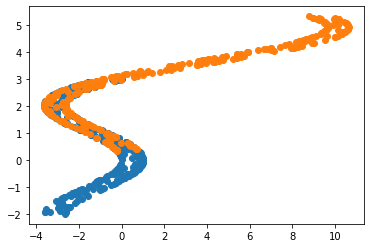

In [20]:
plt.scatter(smps["Y"], smps["X"])
plt.scatter(ints["Y"], ints["X"])
plt.show()

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [48]:
class MDN(nn.Module):
    def __init__(self, n_hidden, n_components, act = torch.nn.LeakyReLU() ):
        super(MDN,self).__init__()
        self.components = n_components
        nh = len(n_hidden)
        l = []
        for i in range(1,nh-1):
            l.append(
                nn.Linear(n_hidden[i-1],n_hidden[i]) 
            )
            l.append(
                act
            )
            #l.append(
            #    nn.BatchNorm1d(n_hidden[i])
            #)
        
        l = l + [nn.Linear(n_hidden[nh-2],n_hidden[nh-1]),act]
        #print(l)
        self.z_h = nn.Sequential( *l )
        
        self.z_pi = nn.Linear(n_hidden[-1], n_components)
        self.z_mu = nn.Linear(n_hidden[-1], n_components)
        self.z_sigma = nn.Linear(n_hidden[-1], n_components)
        
    def forward(self, x):
        z_h = self.z_h(x)
        pi = F.softmax(self.z_pi(z_h), -1)
        mu = self.z_mu(z_h)
        
        sigma = torch.nn.ELU()(self.z_sigma(z_h)) + 1
        #sigma = torch.exp(self.z_sigma(z_h))
        return pi, mu, sigma
    
    def loss(pi_mu_sigma, y, reduce=True, entropy_reg=True):
        pi, mu, sigma = pi_mu_sigma
        m = torch.distributions.Normal(loc=mu, scale=sigma)
        
        log_prob_y = m.log_prob(y) ## y | theta
        
        lp = torch.log(pi)
        
        log_prob_pi_y = log_prob_y + lp
        loss = -torch.logsumexp(log_prob_pi_y, dim=1) # log ( sum_i (exp xi) )
        
        if entropy_reg:
            entropy = -torch.sum(lp * pi,dim=1)/ pi.shape[1]
            loss = loss - 0.5 * entropy
        
        if reduce:
            return torch.mean(loss)
        else:
            return loss

In [49]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, n, scm, features ="X", labels="Y"):
        'Initialization'
        smps = scm._sample(n)
        self.X_train =smps[features]
        self.Y_train =smps[labels]

    def __len__(self):
        'Denotes the total number of samples'
        return self.X_train.shape[0]

    def __getitem__(self, index):
        'Generates one sample of data'

        return torch.tensor(self.X_train[index],dtype=torch.float32), torch.tensor(self.Y_train[index],dtype=torch.float32)

In [50]:
from torch_lr_finder import LRFinder

def lrfind(model,scm,features="X",labels="Y",epoch=100,batch=248,loss=MDN.loss):
    optim = torch.optim.AdamW(model.parameters(), lr=1e-6)
    trainloader = DataLoader(
        Dataset(batch*epoch, scm, features=features, labels=labels), 
        batch_size=batch, 
        shuffle=False)

    lr_finder = LRFinder(model, optim, loss, device="cpu")
    lr_finder.range_test(trainloader, end_lr=10, num_iter=100, step_mode='exp')
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset()

In [51]:
def train(model, base, lr, features, labels,batch=248, epoch=300):

    optim = torch.optim.AdamW(model.parameters(), lr=lr,amsgrad=True)

    lossap = []

    for i in range(epoch):
        smps = base._sample(batch)
        X_train = torch.tensor(smps[features], dtype=torch.float32)
        Y_train = torch.tensor(smps[labels], dtype=torch.float32)

        y_h = model.forward(X_train)
        energy = MDN.loss(y_h, Y_train)
        optim.zero_grad()
        energy.backward()
        optim.step()

        lossap.append(energy.detach().numpy())
        
    return lossap


Learning rate search finished. See the graph with {finder_name}.plot()


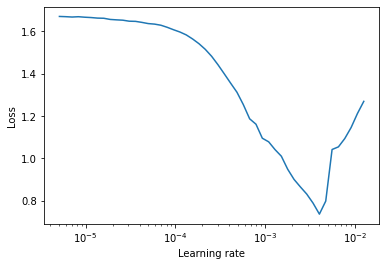

In [52]:
model = MDN([1 ,200], 8)
lrfind(model,base,features="Y",labels="X")


Learning rate search finished. See the graph with {finder_name}.plot()


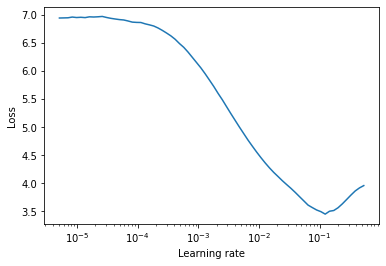

In [53]:
model = MDN([1 ,200], 8)
lrfind(model,base,features="X",labels="Y")

In [54]:
def fit(base, model, heads=1, lr=1e-4,features="X",labels="Y", traini = True):
    #model = MDN([1,200], 12)
    

    lossap=None
    if traini :
        lossap = train(model,base,lr,features,labels, epoch= 5000)
        plt.plot(lossap)
        plt.show()
    
    smps= base._sample(300)
        
    xx = np.sort(smps[features].ravel()).reshape(-1,1)
    xx = torch.tensor(xx,dtype=torch.float32)

    pi, mu, sigma = model.forward(xx)

    #pi = F.softmax(pi,dim=1)
    #sigma = torch.exp(sigma)


    a = torch.sum(pi * mu, dim=1)

    plt.scatter(smps[features], smps[labels])
    plt.plot(xx.numpy().ravel(), a.detach().numpy(),c="black")
    for i in range(heads):
        plt.plot(xx.numpy().ravel(), mu[:,i].detach().numpy())

    plt.show()
    
    return model, lossap

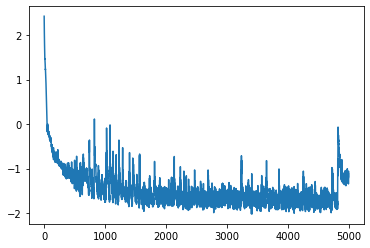

IndexError: index 3 is out of bounds for dimension 1 with size 3

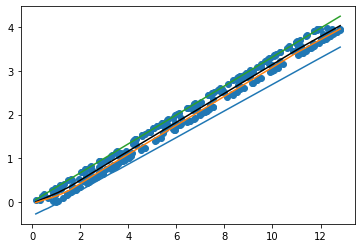

In [72]:
modelyx, plotyx = fit(base,MDN([1,32,32], 3),10,1e-3,"Y","X")
modelxy, plotxy = fit(base,MDN([1,32,32], 3),10,1e-3,"X","Y")

In [ ]:
## generalization
fit(transfer,modelyx,10,1e-3,"Y","X",False)
fit(transfer,modelxy,10,1e-3,"X","Y",False)

In [ ]:
### log Likelihood report. 

dts = base._sample(3000)
X_t = torch.tensor(dts["X"], dtype=torch.float32)
Y_t = torch.tensor(dts["Y"], dtype=torch.float32)

print(" likelihood X->Y : " + str(MDN.loss( modelxy.forward(X_t), Y_t, entropy_reg=False)))
print(" likelihood Y->X : " + str(MDN.loss( modelyx.forward(Y_t), X_t, entropy_reg=False)))

plt.plot(plotyx, label="Y->X")
plt.plot(plotxy, label="X->Y")
plt.legend()
plt.show()

In [63]:
from scipy.stats import norm as normal
def plot_normal_mix(x,pis, mus, sigmas, ax, label='', comp=True):
    """
    Plots the mixture of Normal models to axis=ax
    comp=True plots all components of mixtur model
    """
    #x = np.linspace(-10.5, 10.5, 250)
    final = np.zeros_like(x)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
        temp = normal.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
        if comp:
            ax.plot(x, temp, label='Normal ' + str(i))
    ax.plot(x, final, label='Mixture of Normals ' + label)
    #ax.legend(fontsize=6)
    
def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """
    Draws samples from mixture model. 
    Returns 2 d array with input X and sample from prediction of Mixture Model
    """
    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j,(weights, means, std_devs) in enumerate(zip(pred_weights, pred_means, pred_std)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j,1]= normal.rvs(means[index], std_devs[index], size=1)
        samples[j,0]= x[j]
        if j == amount -1:
            break
    return samples

In [64]:
def interactiveplot(xx,yy,model):

    for ii in xx:
        X_train = torch.tensor( [[ii]], dtype=torch.float32)
        
        #print(X_train.shape)
        pis, mus, sigmas = model.forward(X_train)
        
        ##
        pis = list(pis.detach().numpy().ravel())
        mus = list(mus.detach().numpy().ravel())
        sigmas = list(sigmas.detach().numpy().ravel())
        fig, axes = plt.subplots(figsize=(8, 4))

        plot_normal_mix( 
            yy,
            pis,
            mus,
            sigmas,
            axes,
            comp=True
        )

<ipython-input-64-36b166b39740>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(figsize=(8, 4))


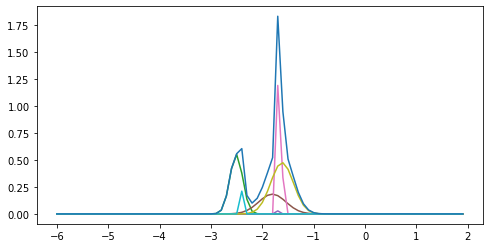

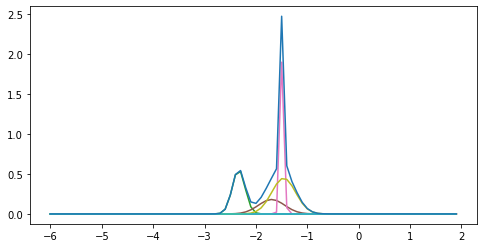

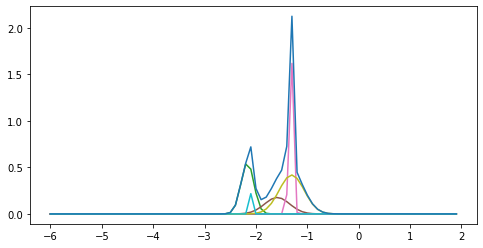

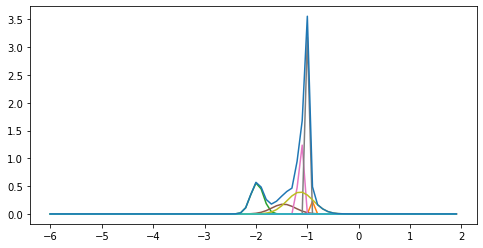

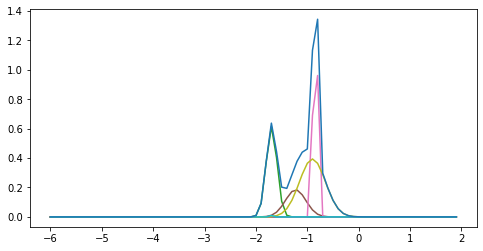

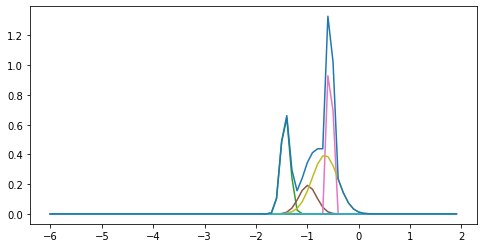

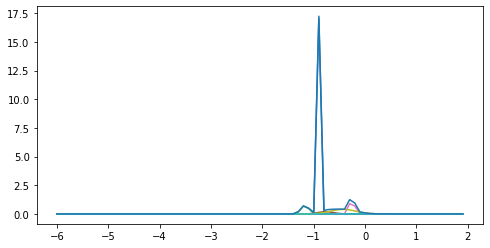

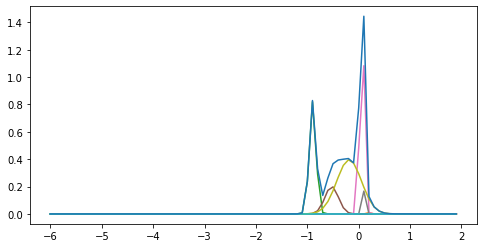

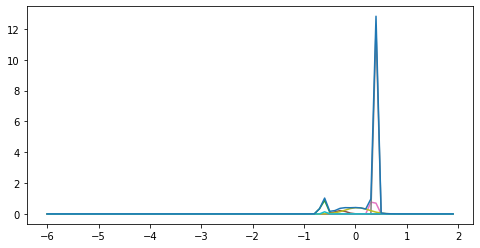

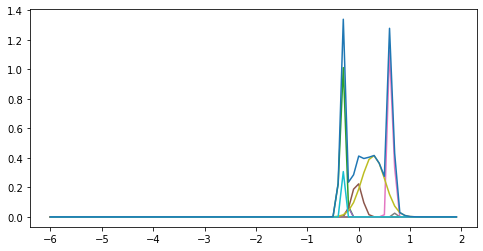

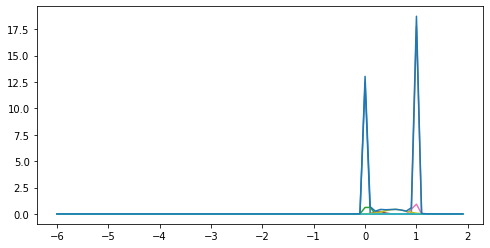

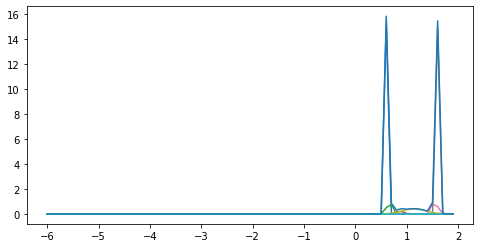

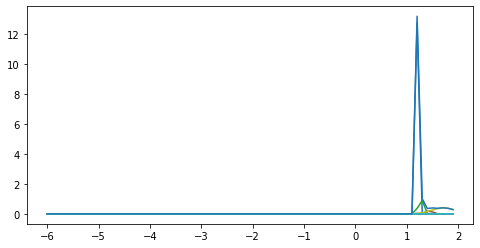

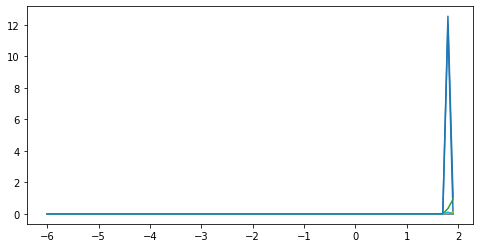

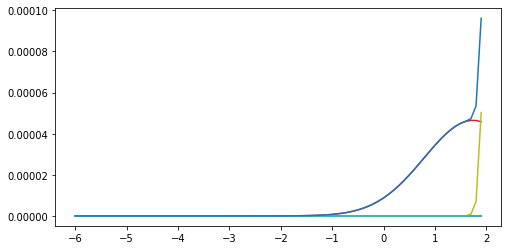

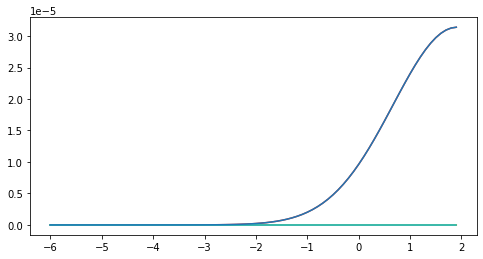

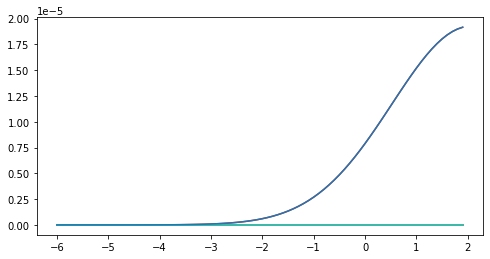

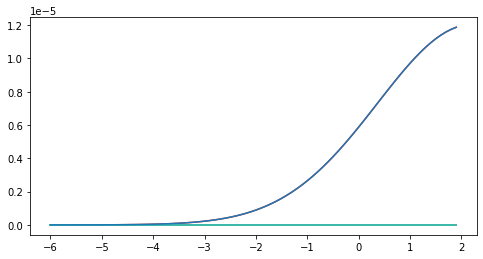

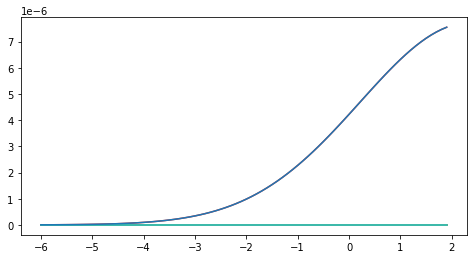

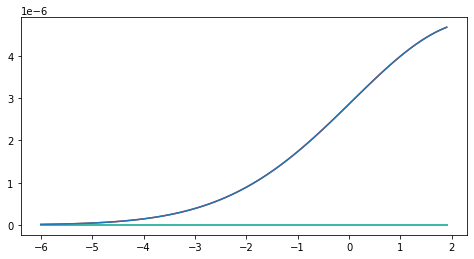

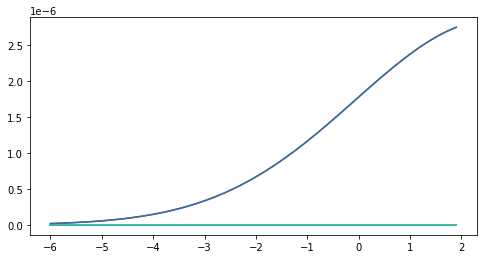

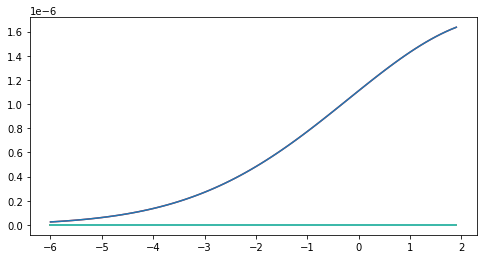

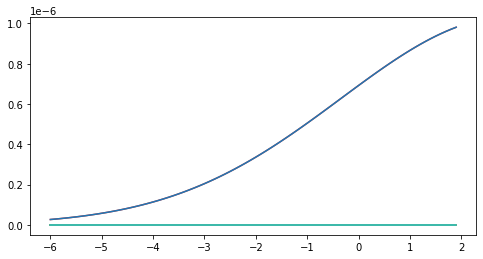

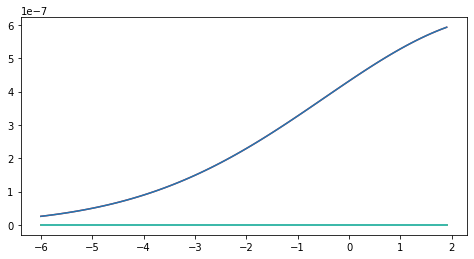

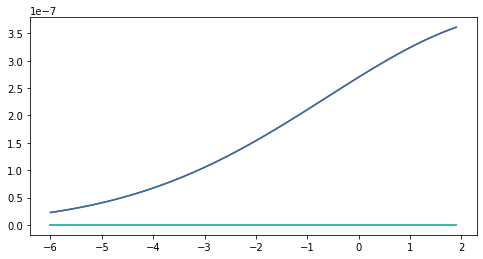

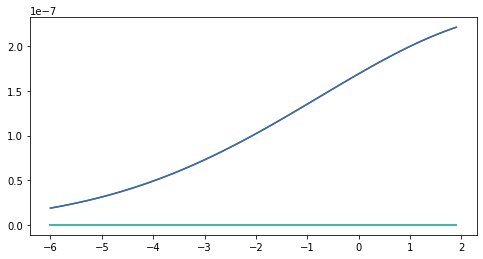

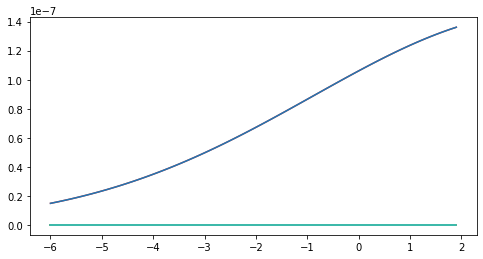

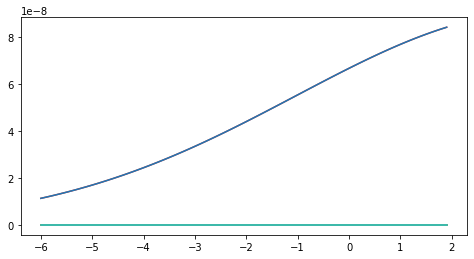

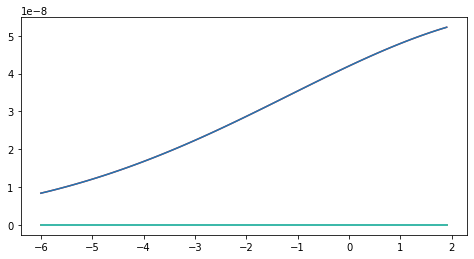

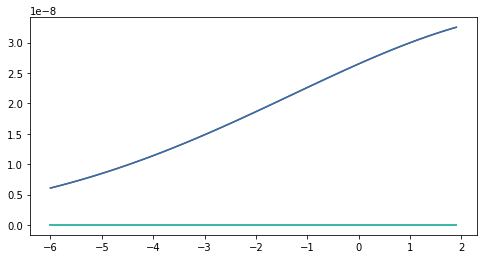

In [65]:
## plotting the conditionals
yy= np.arange(-6,2,0.1)
xx= np.arange(-2,4,0.2) 
interactiveplot(xx,yy,modelxy)


<ipython-input-64-36b166b39740>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(figsize=(8, 4))


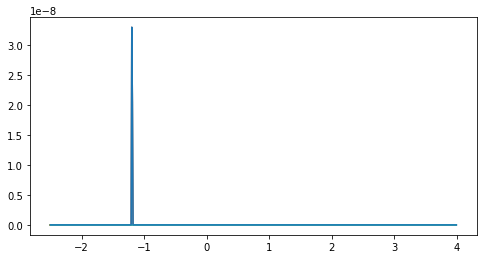

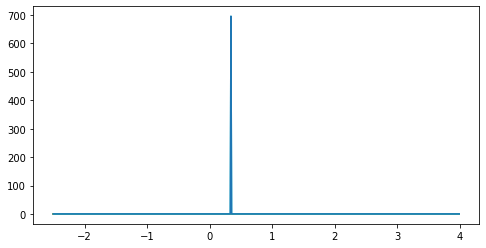

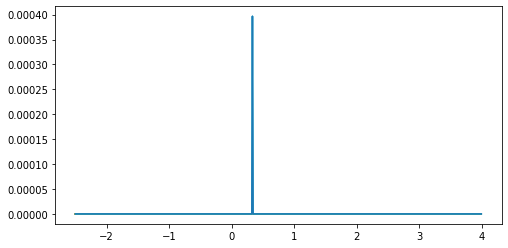

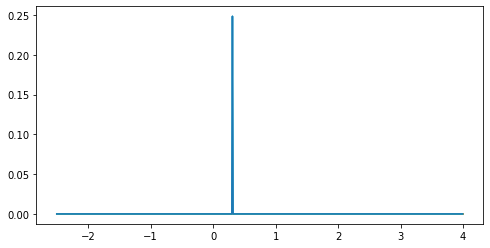

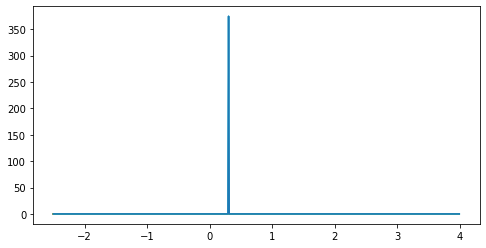

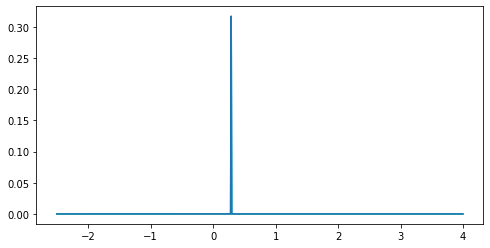

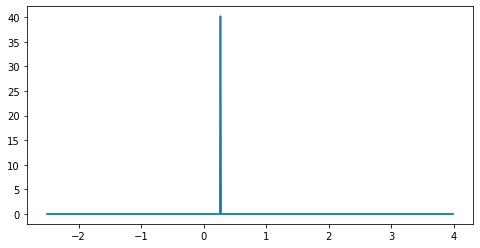

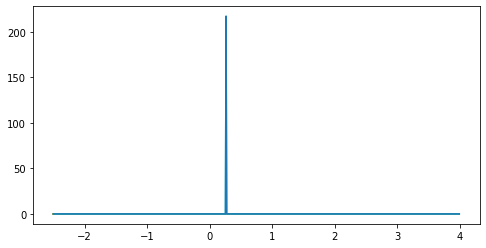

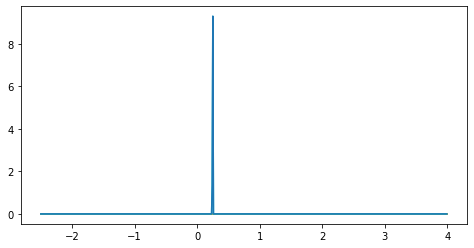

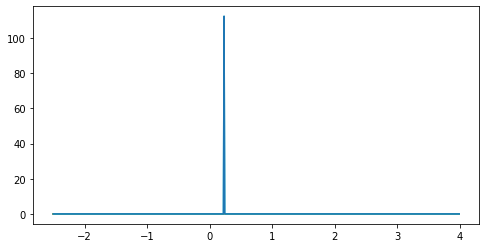

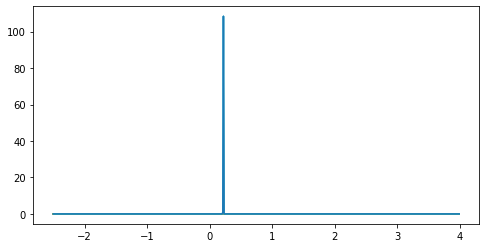

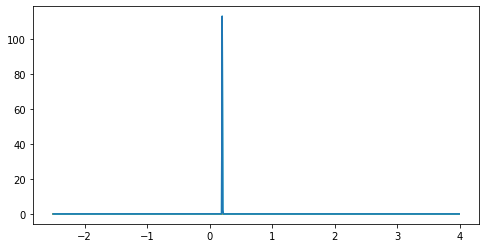

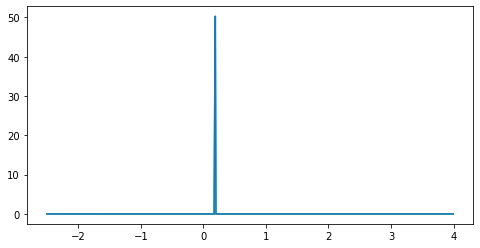

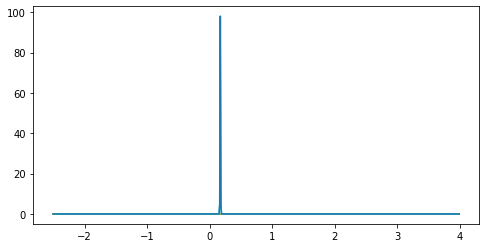

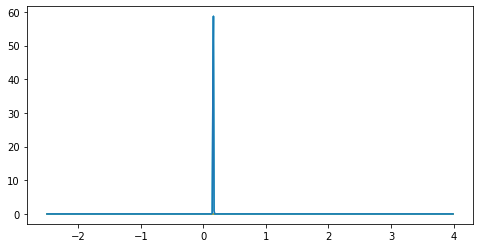

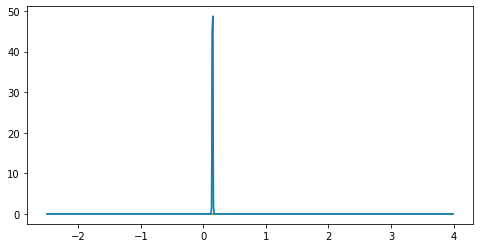

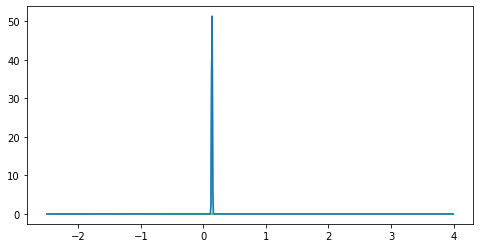

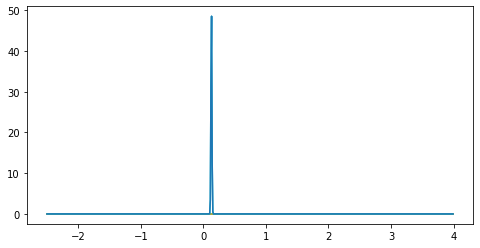

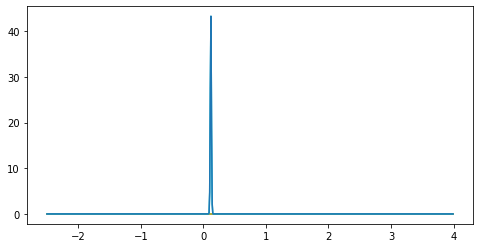

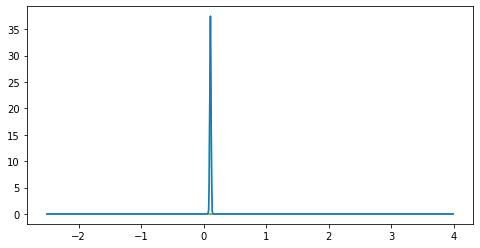

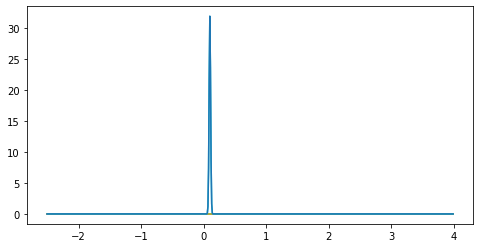

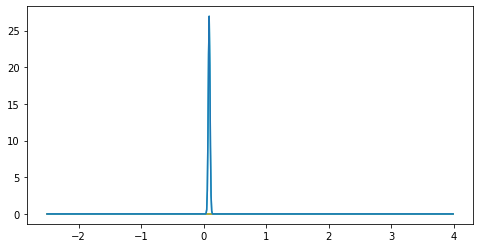

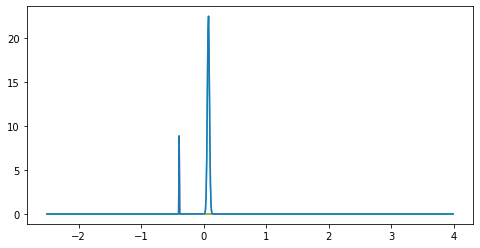

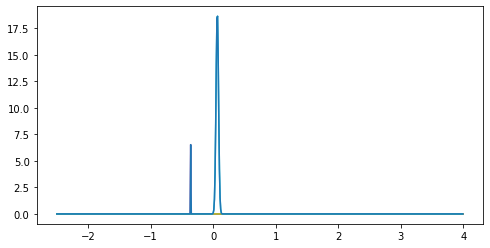

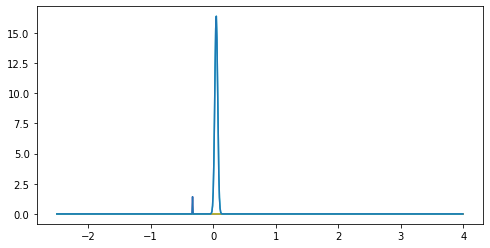

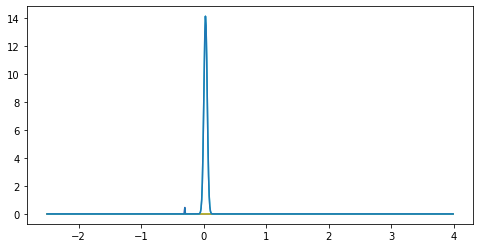

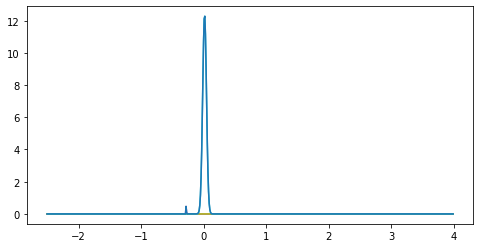

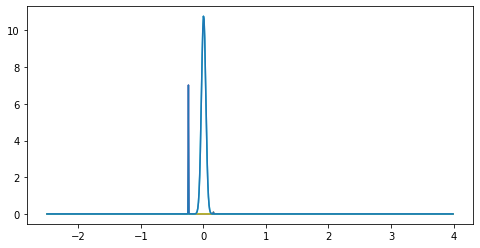

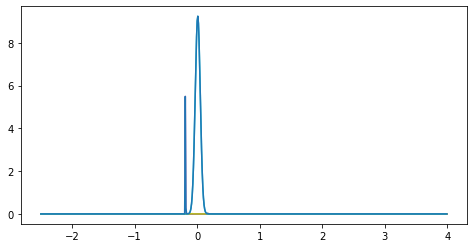

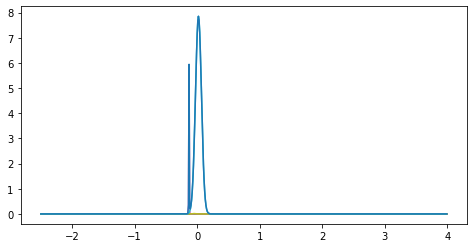

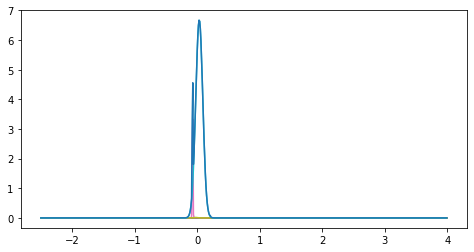

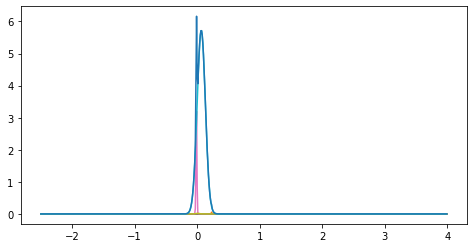

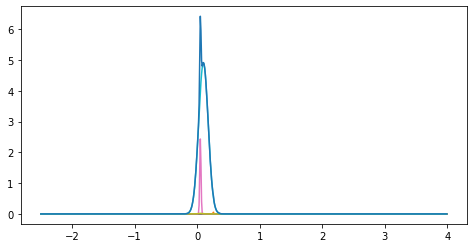

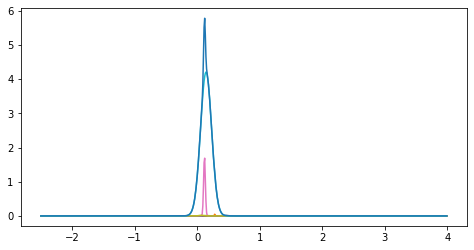

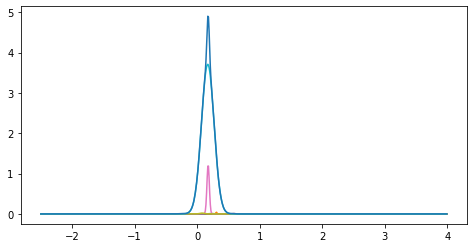

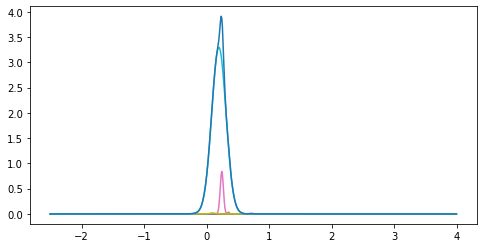

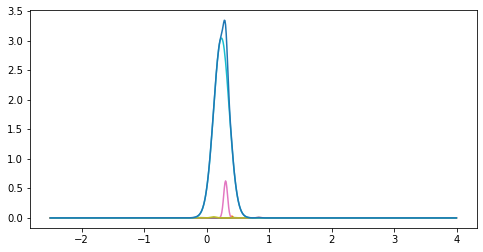

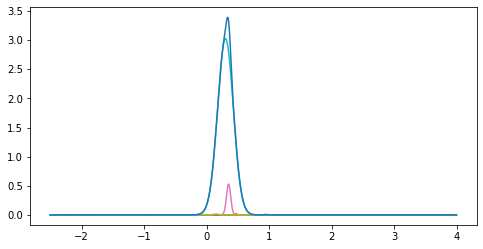

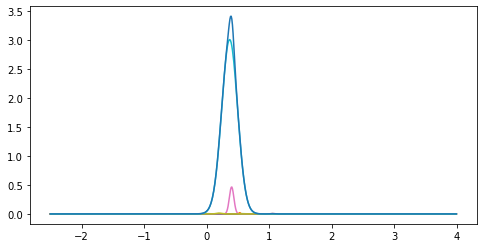

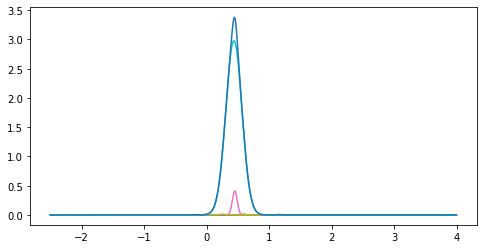

In [66]:
## ploting the conditionals
yy= np.arange(-6,2,0.2)
xx= np.arange(-2.5,4,0.01) 
interactiveplot(yy,xx,modelyx)

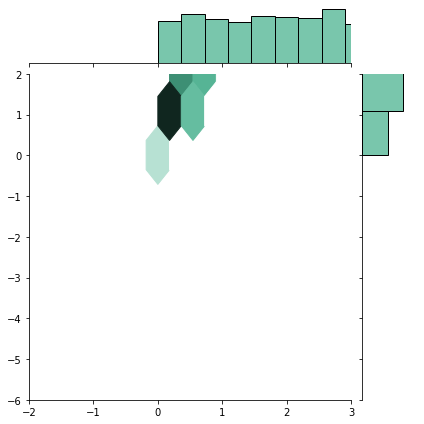

In [67]:
##########################
x = base._sample(1000)["X"]
X_train = torch.tensor(x, dtype=torch.float32)

pis, mus, sigmas = modelxy.forward(X_train)
pis = pis.detach().numpy()
mus = mus.detach().numpy()
sigmas = sigmas.detach().numpy()

a = sample_from_mixture(x, pis, mus, sigmas, 1000)
sns.jointplot(x=a[:,0], y=a[:,1], kind="hex", color="#4CB391", 
              ylim=(-6,2), xlim=(-2,3))
plt.show()

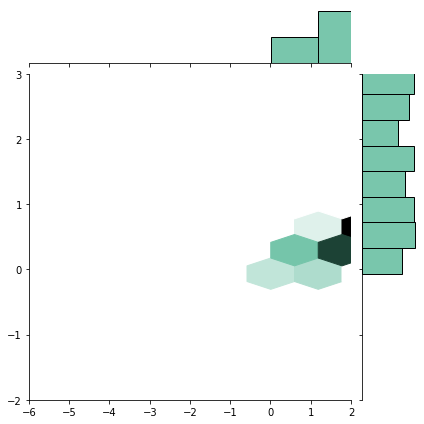

In [68]:
##########################
x = base._sample(1000)["Y"]
X_train = torch.tensor(x, dtype=torch.float32)

pis, mus, sigmas = modelyx.forward(X_train)
pis = pis.detach().numpy()
mus = mus.detach().numpy()
sigmas = sigmas.detach().numpy()

a = sample_from_mixture(x, pis, mus, sigmas, 1000)
sns.jointplot(x=a[:,0], y=a[:,1], kind="hex", color="#4CB391", 
              ylim=(-2,3), xlim=(-6,2))
plt.show()

In [69]:
## finally, saving the model. 
torch.save(modelxy,"model_x->y")
torch.save(modelyx,"model_y->x")

In [70]:
# Saving scm
base.save("base.scm")
transfer.save("transfer.scm")

In [71]:
#### check dataset

#train(MDN([1,100],12),base,1e-3,"X","Y", epoch= 1)[-1]
delta = np.zeros(np.arange(30, 1000, 100).shape)

for j in range(5):
    print(j)
    dta = {}
    dtb = {}
    for i in np.arange(30, 1000, 100):
        dta[i] = train(MDN([1,100],12),base,1e-3,"X","Y", epoch=i)[-1]
        dtb[i] = train(MDN([1,100],12),base,1e-3,"Y","X", epoch=i)[-1]

    delta = delta + np.array( list(dta.values()) ) - np.array( list(dtb.values()))
    
delta = delta/5

0
1
2
3
4


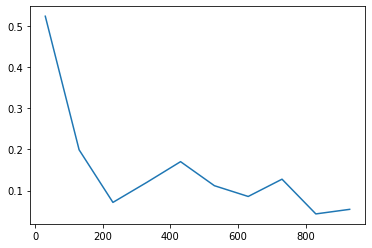

In [201]:
plt.plot(dta.keys(), delta)
plt.show()